### Import Library dan Dataset

In [1]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

I0000 00:00:1760112524.015192  212829 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1760112524.048073  212829 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1760112525.147076  212829 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sorr/anaconda3/envs/nightly_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProg

In [2]:
tf.random.set_seed(42)
print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.21.0-dev20251009
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


W0000 00:00:1760112526.956571  212829 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [3]:
df = pd.read_csv('./data/data_cleaned.csv')
df.head()

,Tweet,Label
0,asa i lop yuk pul monyetku cakepku sehat sehat...,Cinta
1,enggak enak banget bangun bangun badan panas,Sedih
2,aneh enggak sih padahal dia lebih sering kelua...,Marah
3,kasihan ceweknya pasti sedih banget dia ya kal...,Marah
4,ya kecewa,Sedih


### Persiapan Dataset

In [4]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])

# Splitting dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Tweet"].tolist(), df["LabelEncoded"].tolist(),
    test_size=0.3, stratify=df["LabelEncoded"], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

### Tokenisasi

In [5]:
# Mengambil Tokenizer dari model XLM-RoBERTa
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors="tf"
    )


train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
W0000 00:00:1760112527.886606  212829 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1760112528.187299  212829 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8547 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


In [6]:
# Data Batching dan Batch Preparation
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.convert_to_tensor(train_labels)
)).shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    tf.convert_to_tensor(val_labels)
)).batch(16).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.convert_to_tensor(test_labels)
)).batch(16).prefetch(tf.data.AUTOTUNE)

### Fine-Tuning

In [7]:
# Menyiapkan Model untuk Fine-Tuning
num_labels = len(set(df["LabelEncoded"]))

model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    use_safetensors=False,
    num_labels=num_labels
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [9]:
# Training Loop
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3


I0000 00:00:1760112545.244503  212935 service.cc:158] XLA service 0x7579e6291fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760112545.244545  212935 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1760112545.250389  212935 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760112545.262512  212935 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1760112545.329139  212935 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


217/217 [==============================] - 61s 167ms/step - loss: 0.9814 - accuracy: 0.6544 - val_loss: 0.5842 - val_accuracy: 0.7954
Epoch 2/3
217/217 [==============================] - 34s 158ms/step - loss: 0.4454 - accuracy: 0.8612 - val_loss: 0.4879 - val_accuracy: 0.8291
Epoch 3/3
217/217 [==============================] - 33s 151ms/step - loss: 0.3246 - accuracy: 0.9005 - val_loss: 0.4493 - val_accuracy: 0.8520


### Evaluasi

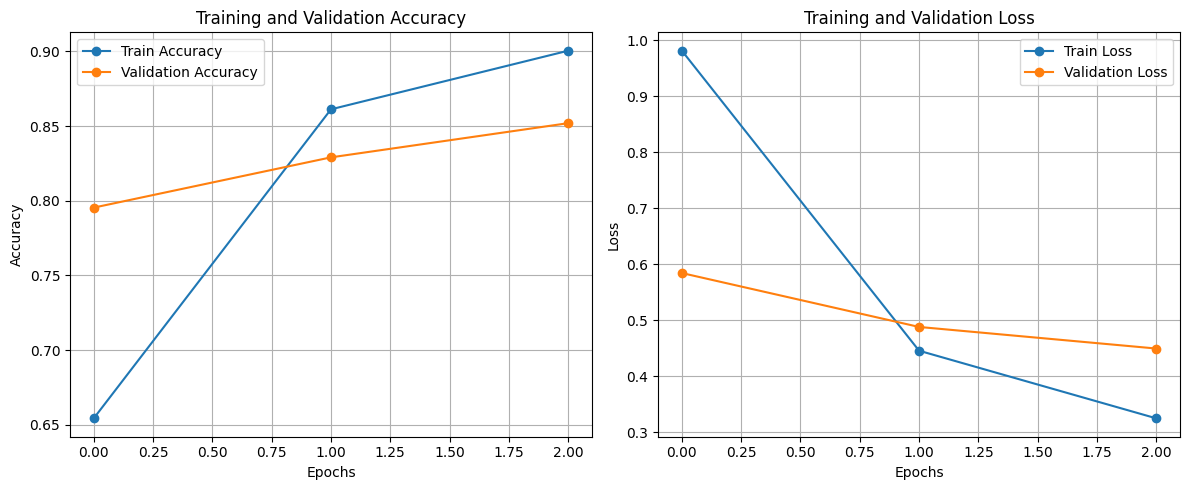

In [10]:
# Visualisasi Learning Curve
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Evaluasi
pred_logits = model.predict(test_dataset).logits
pred_labels = np.argmax(pred_logits, axis=1)
true_labels = np.array(test_labels)
label_names = le.classes_.tolist()

print("\nClassification Report:")
print(classification_report(
    true_labels, 
    pred_labels,
    target_names=label_names, 
    digits=4))

47/47 [==============================] - 4s 63ms/step

Classification Report:
              precision    recall  f1-score   support

       Cinta     0.7556    0.9027    0.8226       113
     Gembira     0.8681    0.8404    0.8541       188
       Marah     0.8428    0.8535    0.8481       157
       Sedih     0.8582    0.7718    0.8127       149
       Takut     0.8797    0.8603    0.8699       136

    accuracy                         0.8425       743
   macro avg     0.8409    0.8457    0.8415       743
weighted avg     0.8458    0.8425    0.8426       743



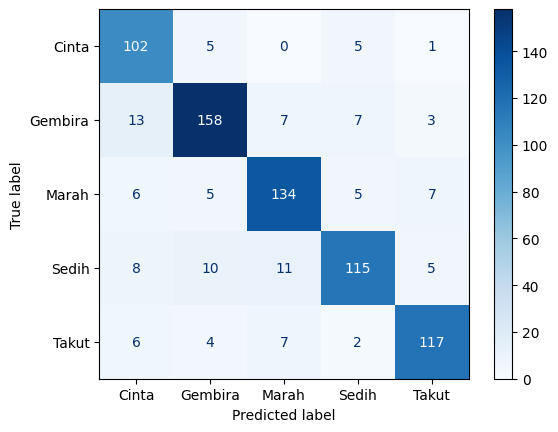

In [12]:
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)